<a href="https://colab.research.google.com/github/melody-gold/csci303_project/blob/main/CSCI303_Semester_Proj.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# Filter warnings
import warnings
warnings.filterwarnings("ignore", category=Warning)
warnings.simplefilter(action='ignore', category=FutureWarning)

# Import libraries
import folium
import io
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import requests
import seaborn as sns

from IPython.display import display
from scipy.stats import mode
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

In [3]:
# Function to read data from host location on GitHub
def load_csv_from_url(url):
    response = requests.get(url)
    response.raise_for_status()
    return pd.read_csv(io.StringIO(response.text))

# Read the data and add some error handling for file not found
df = load_csv_from_url("https://raw.githubusercontent.com/Dr-Queue/CSCI303_DATA/refs/heads/main/SCHOOL_DATA.csv")

# Keep only high school data
df = df[df['school_level'] == 'High']

# Keep only some columns
df = df[['enrollment', 'school_name', 'city_location', 'latitude', 'longitude', 'urban_centric_locale',
        'sch_internet_wifi', 'students_SAT_ACT', 'enrl_biology', 'students_susp_in_sch', 'students_susp_out_sch_single', 'students_susp_out_sch_multiple', 'days_suspended',
        'suspensions_instances', 'teachers_fte_crdc', 'teachers_certified_fte', 'teachers_absent_fte', 'instructional_aides_fte', 'counselors_fte',
        'support_fte', 'social_workers_fte', 'administration_fte', 'psychologists_fte', 'nurses_fte', 'law_enforcement_fte', 'security_guard_fte',
        'salaries_teachers', 'salaries_total', 'salaries_instruc_staff', 'salaries_instructional_aides', 'salaries_support', 'salaries_administration',
        'expenditures_nonpersonnel',  'title_i_eligible']]

# Read in the graduation rate data
df_grad = load_csv_from_url("https://raw.githubusercontent.com/Dr-Queue/CSCI303_DATA/refs/heads/main/GRAD_DATA.csv")

# Merge the datasets based on school name
df = df.merge(df_grad[['School Name', '2021 grad rate']],
              left_on='school_name',
              right_on='School Name',
              how='left')

# Drop rows that don't have graduation data or where grad data is '-'
df = df.dropna(subset=['2021 grad rate'])
df = df[df['2021 grad rate'] != '-']

# Rename column to grad_rate and drop the school names
df = df.rename(columns={'2021 grad rate': 'grad_rate'}).drop(columns=['School Name', 'school_name'])


print(df.shape)
# df.info()

(378, 34)


In [4]:
# Data cleaning

# Drop rows with multiple missing values (more than 3)
df_cleaned = df.dropna(thresh=len(df.columns) - 3)

# Remap "Yes" and "No" to 1 and 0
df_cleaned['title_i_eligible'] = df_cleaned['title_i_eligible'].map({'Yes': 1, 'No': 0})
df_cleaned['sch_internet_wifi'] = df_cleaned['sch_internet_wifi'].map({'Yes': 1, 'No': 0})

# Encode urban_centric_locale using one hot encoding
# Grouping into city, suburb, town, and rural to prevent adding lots of new columns
group_mapping = {
    'City, large': 'City',
    'City, midsize': 'City',
    'City, small': 'City',
    'Suburb, large': 'Suburb',
    'Suburb, midsize': 'Suburb',
    'Suburb, small': 'Suburb',
    'Town, remote': 'Town',
    'Town, distant': 'Town',
    'Town, fringe': 'Town',
    'Rural, fringe': 'Rural',
    'Rural, remote': 'Rural',
    'Rural, distant': 'Rural'
}
df_cleaned['locale_group'] = df_cleaned['urban_centric_locale'].map(group_mapping)
df_cleaned = pd.get_dummies(df_cleaned, columns=['locale_group'], prefix='locale')
df_cleaned = df_cleaned.drop(columns=['urban_centric_locale'])

# Convert numeric data stored as strings to floats
df_cleaned[['enrollment', 'salaries_teachers', 'salaries_instruc_staff', 'students_susp_in_sch', 'students_susp_out_sch_single', 'students_susp_out_sch_multiple', 'grad_rate']] = df_cleaned[['enrollment', 'salaries_teachers', 'salaries_instruc_staff', 'students_susp_in_sch', 'students_susp_out_sch_single', 'students_susp_out_sch_multiple','grad_rate']].apply(pd.to_numeric, errors='coerce')

# Fill missing values with median - can refine this later, other fill methods may make more sense
num_cols = df_cleaned.columns.difference(['city_location', 'latitude', 'longitude'])
df_cleaned[num_cols] = df_cleaned[num_cols].fillna(df_cleaned[num_cols].median())
# df_cleaned.info()

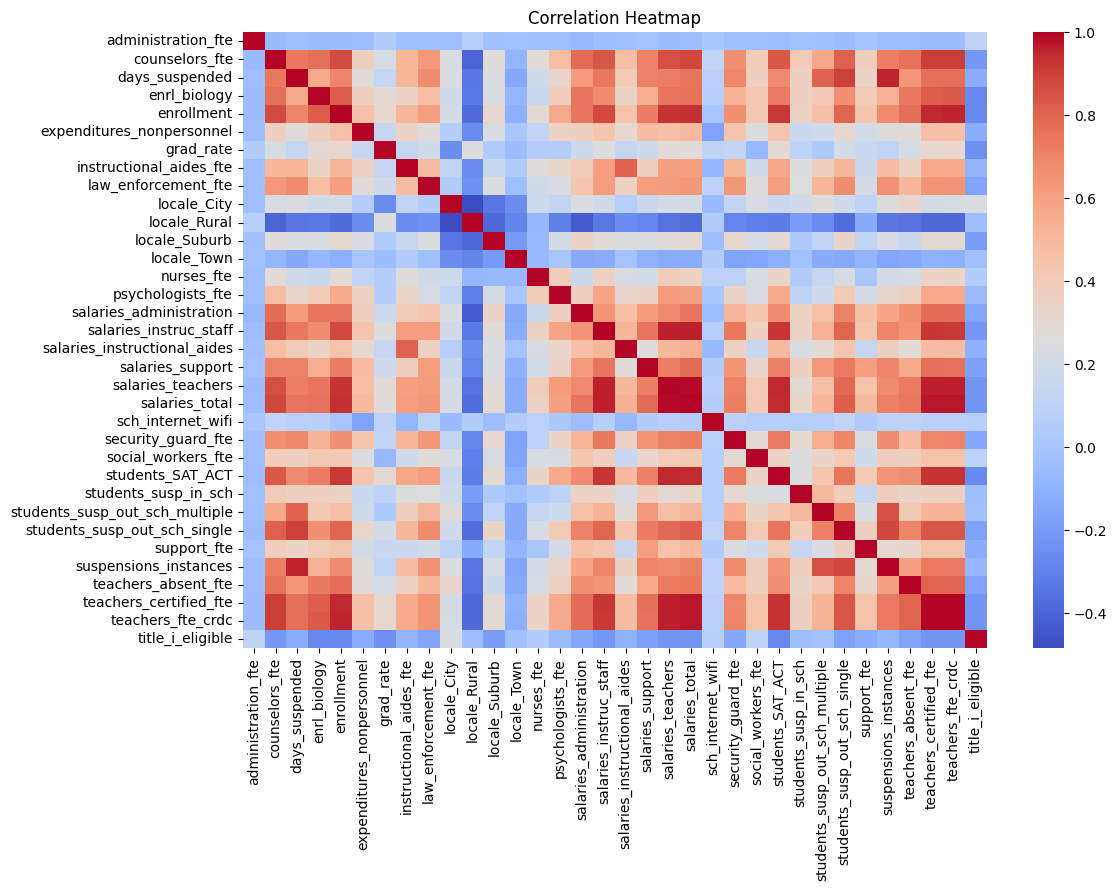

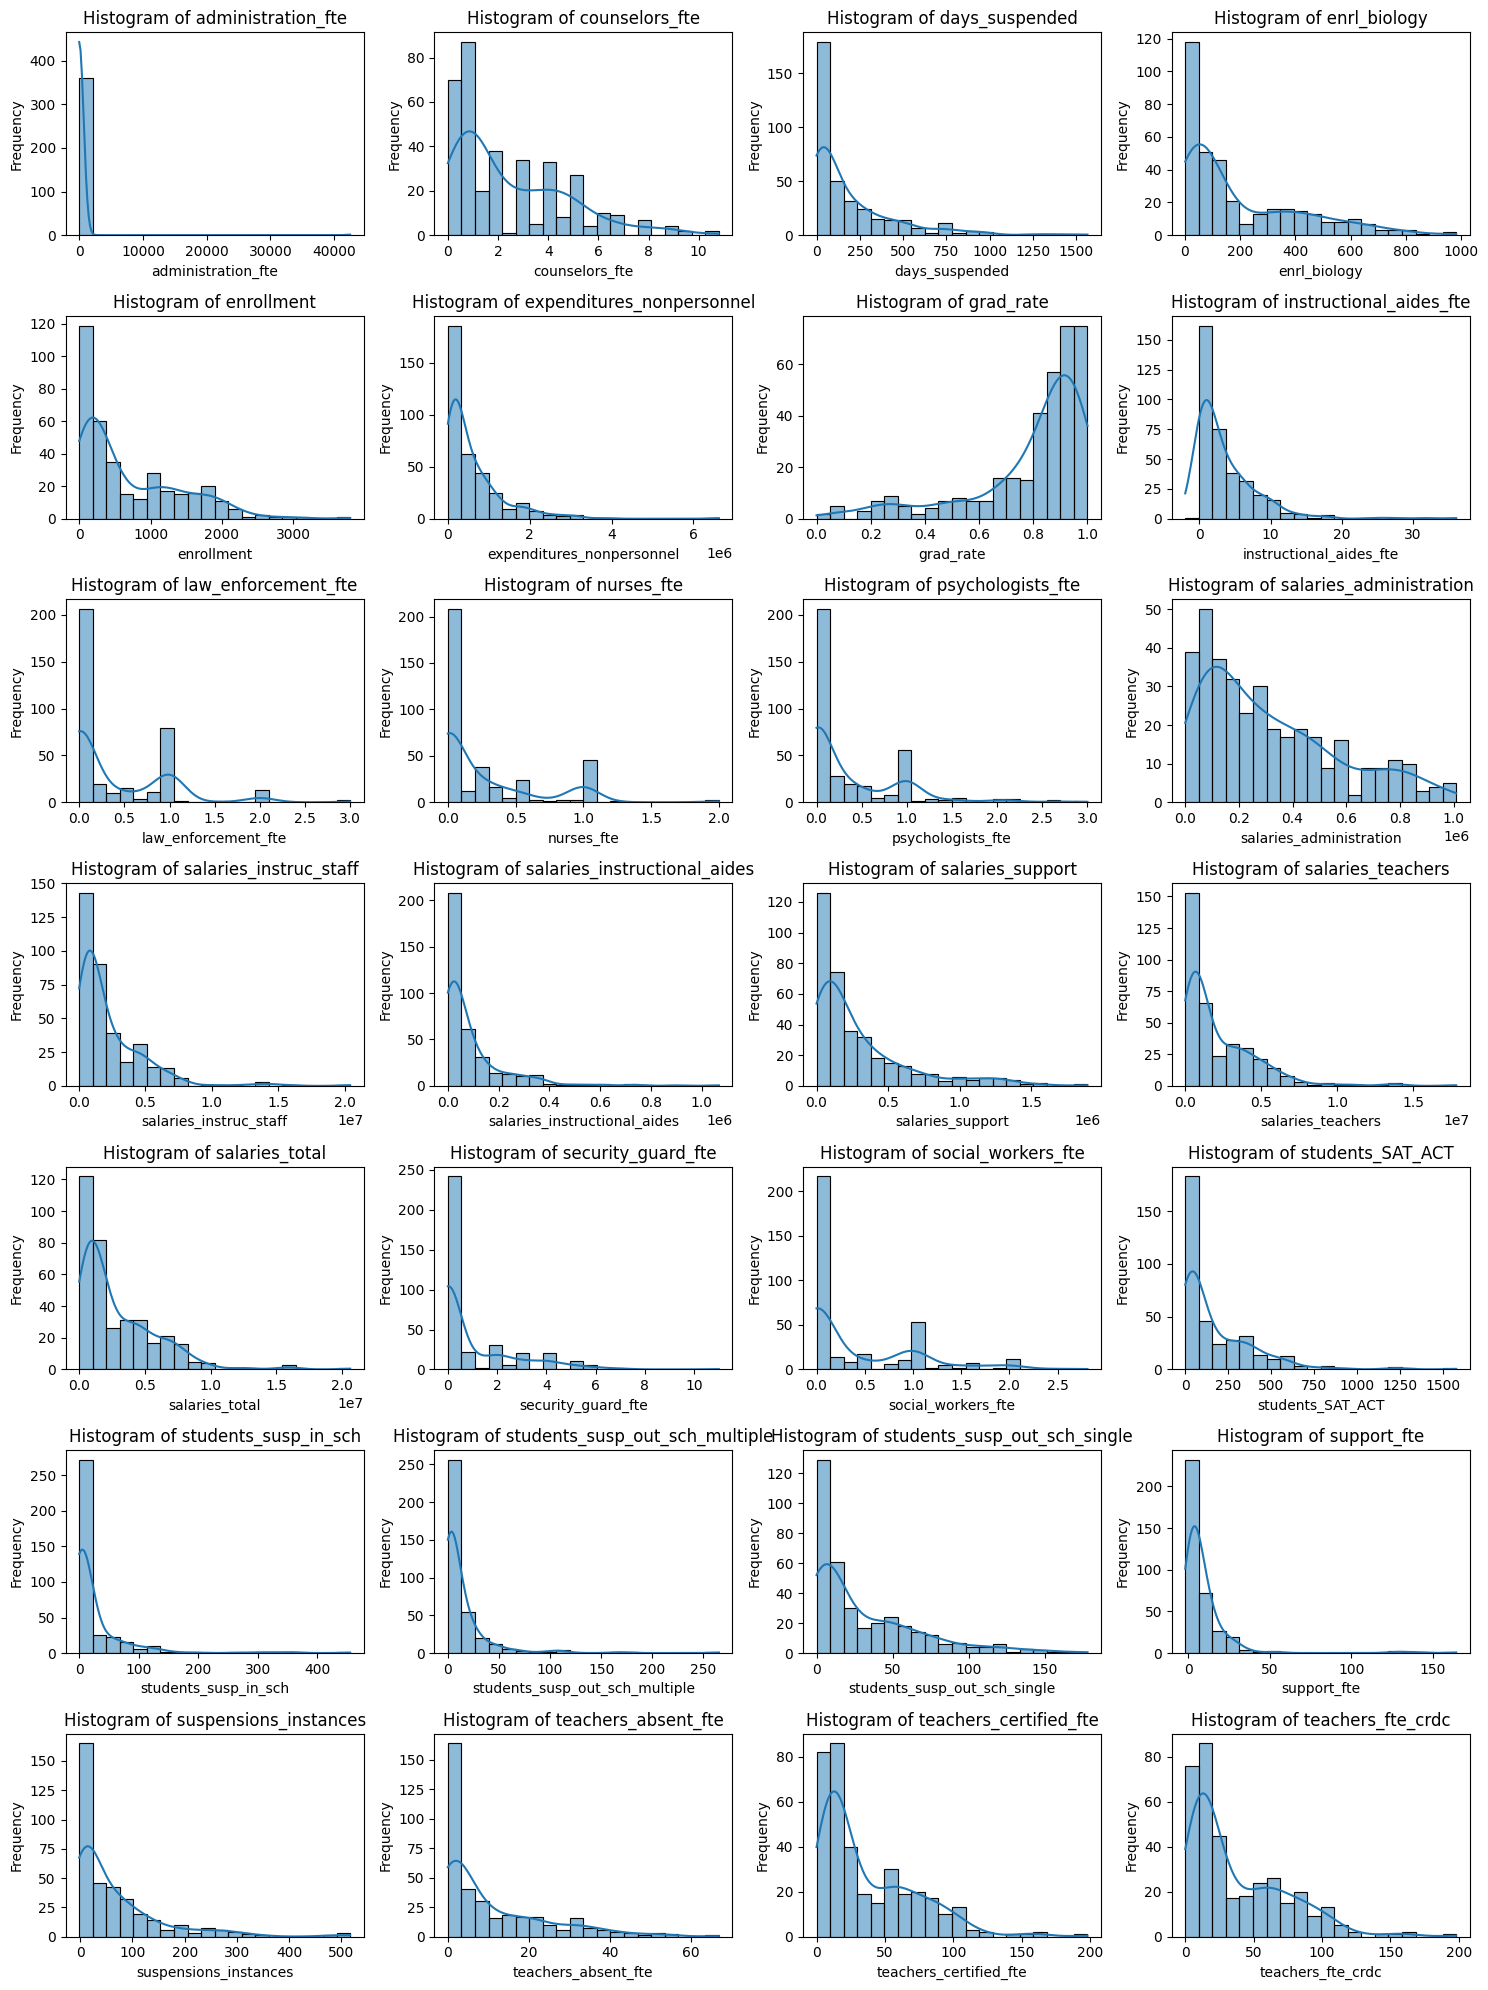

Dataset statistics:



,administration_fte,counselors_fte,days_suspended,enrl_biology,enrollment,expenditures_nonpersonnel,grad_rate,instructional_aides_fte,law_enforcement_fte,nurses_fte,psychologists_fte,salaries_administration,salaries_instruc_staff,salaries_instructional_aides,salaries_support,salaries_teachers,salaries_total,sch_internet_wifi,security_guard_fte,social_workers_fte,students_SAT_ACT,students_susp_in_sch,students_susp_out_sch_multiple,students_susp_out_sch_single,support_fte,suspensions_instances,teachers_absent_fte,teachers_certified_fte,teachers_fte_crdc,title_i_eligible
count,361.000000,361.000000,361.000000,361.000000,361.000000,3.610000e+02,361.000000,361.000000,361.000000,361.000000,361.000000,3.610000e+02,3.610000e+02,3.610000e+02,3.610000e+02,3.610000e+02,3.610000e+02,361.000000,361.000000,361.000000,361.000000,361.000000,361.000000,361.000000,361.000000,361.000000,361.000000,361.000000,361.000000,361.000000
mean,122.227147,2.489418,187.770083,201.119114,700.858726,5.940978e+05,0.791725,3.608587,0.385512,0.249391,0.350499,3.166085e+05,2.224947e+06,8.902647e+04,2.936160e+05,2.194859e+06,2.914967e+06,0.983380,0.968061,0.399695,177.196676,25.217452,13.429363,30.952909,9.219224,64.969529,10.592078,37.423961,38.163435,0.218837
std,2236.608500,2.280215,256.061407,218.454279,703.369943,7.394952e+05,0.222961,4.602581,0.557807,0.384392,0.533247,2.553652e+05,2.575463e+06,1.365926e+05,3.449982e+05,2.446086e+06,2.960961e+06,0.128022,1.672235,0.598162,220.266386,53.375014,25.986131,35.663481,17.666998,87.432238,13.051166,34.500427,34.905561,0.414031
min,-2.000000,0.000000,-2.000000,1.000000,0.000000,-2.000000e+00,0.000000,-2.000000,0.000000,0.000000,0.000000,-2.000000e+00,1.403500e+04,-2.000000e+00,-2.000000e+00,4.450000e+03,-2.000000e+00,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,-2.000000,-2.000000,0.000000,0.000000,0.000000,0.000000
25%,1.500000,1.000000,16.000000,35.000000,132.000000,1.220140e+05,0.734400,0.530000,0.000000,0.000000,0.000000,1.053803e+05,5.183620e+05,9.049000e+03,5.906776e+04,5.013770e+05,7.364320e+05,1.000000,0.000000,0.000000,28.000000,0.000000,1.000000,4.000000,1.840000,7.000000,1.000000,10.760000,11.000000,0.000000
50%,3.180000,1.900000,78.000000,100.000000,387.000000,3.018480e+05,0.878600,2.000000,0.000000,0.000000,0.000000,2.518635e+05,1.266092e+06,3.896000e+04,1.655301e+05,1.171892e+06,1.717632e+06,1.000000,0.000000,0.000000,77.000000,5.500000,4.000000,16.000000,4.750000,27.000000,5.000000,22.000000,23.000000,0.000000
75%,6.000000,4.000000,269.000000,336.000000,1180.000000,8.256390e+05,0.938000,5.250000,1.000000,0.340000,0.600000,4.636382e+05,3.010161e+06,1.089916e+05,3.888888e+05,3.422650e+06,4.433559e+06,1.000000,2.000000,0.920000,283.000000,22.000000,15.000000,48.000000,11.000000,87.000000,17.200000,58.500000,62.000000,0.000000
max,42500.000000,10.800000,1566.000000,982.000000,3797.000000,6.618479e+06,1.000000,36.080000,3.000000,2.000000,3.000000,1.009812e+06,2.040226e+07,1.068014e+06,1.892603e+06,1.781038e+07,2.062155e+07,1.000000,11.000000,2.810000,1575.000000,455.000000,265.000000,178.000000,164.470000,517.000000,67.000000,198.200000,198.000000,1.000000


In [5]:
# Data visualization and exploration

# Plot correlation heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(df_cleaned[num_cols].corr(), annot=False, fmt='.2f', cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

# Numerical columns to plot - doesn't make sense to plot binary features
num_cols_plt = df_cleaned.columns.difference(['city_location', 'latitude','longitude', 'locale_City', 'locale_Rural',
                                              'locale_Suburb', 'locale_Town', 'sch_internet_wifi', 'title_i_eligible'])
# Plotting histograms of numerical values
plt.figure(figsize=(15, 20))
for i, col in enumerate(df_cleaned[num_cols_plt]):
    plt.subplot(7, 4, i + 1)
    sns.histplot(df_cleaned[col], bins=20, kde=True)
    plt.title(f'Histogram of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

# Dataset descriptive statistics
print("Dataset statistics:\n")
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    display(df_cleaned[num_cols].describe())

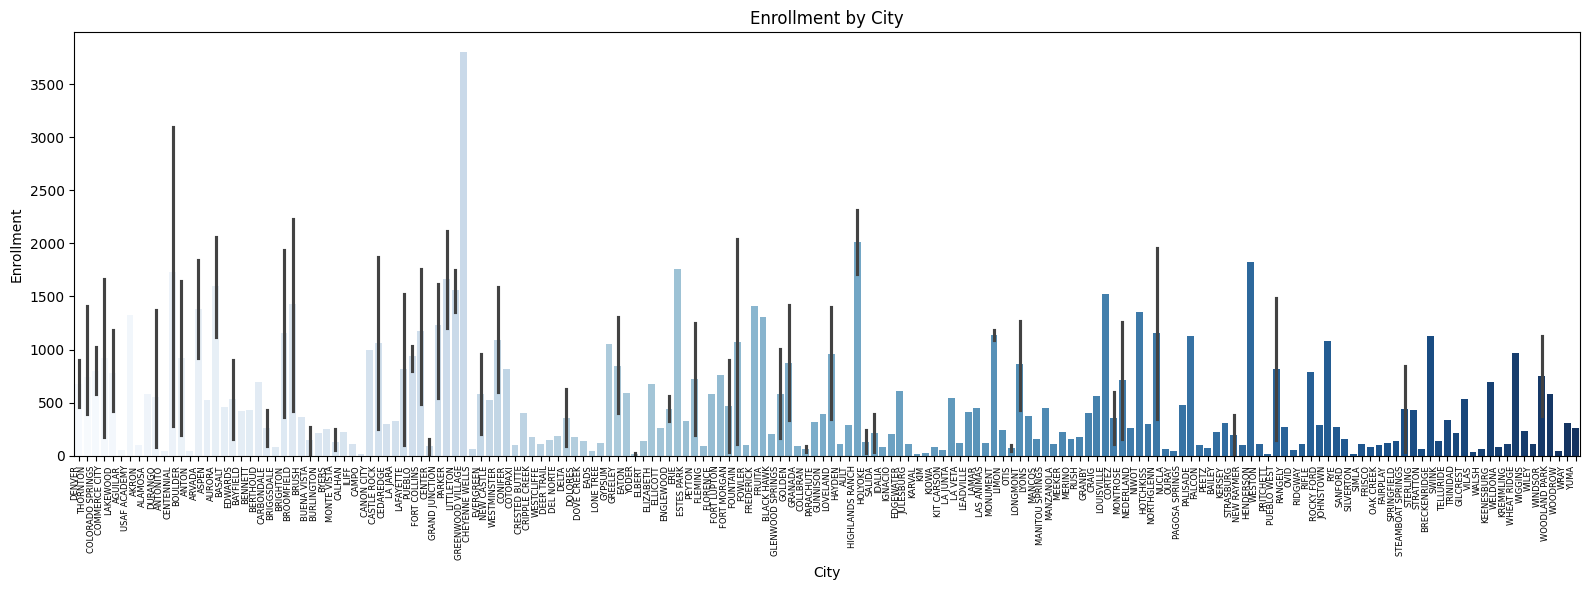

In [6]:
# Create the bar chart
plt.figure(figsize=(16, 6))
sns.barplot(x='city_location', y='enrollment', data=df_cleaned, palette='Blues')
plt.title('Enrollment by City')
plt.xlabel('City')
plt.ylabel('Enrollment')
plt.xticks(rotation=90, ha='right', fontsize=6)
plt.tight_layout()
plt.show()

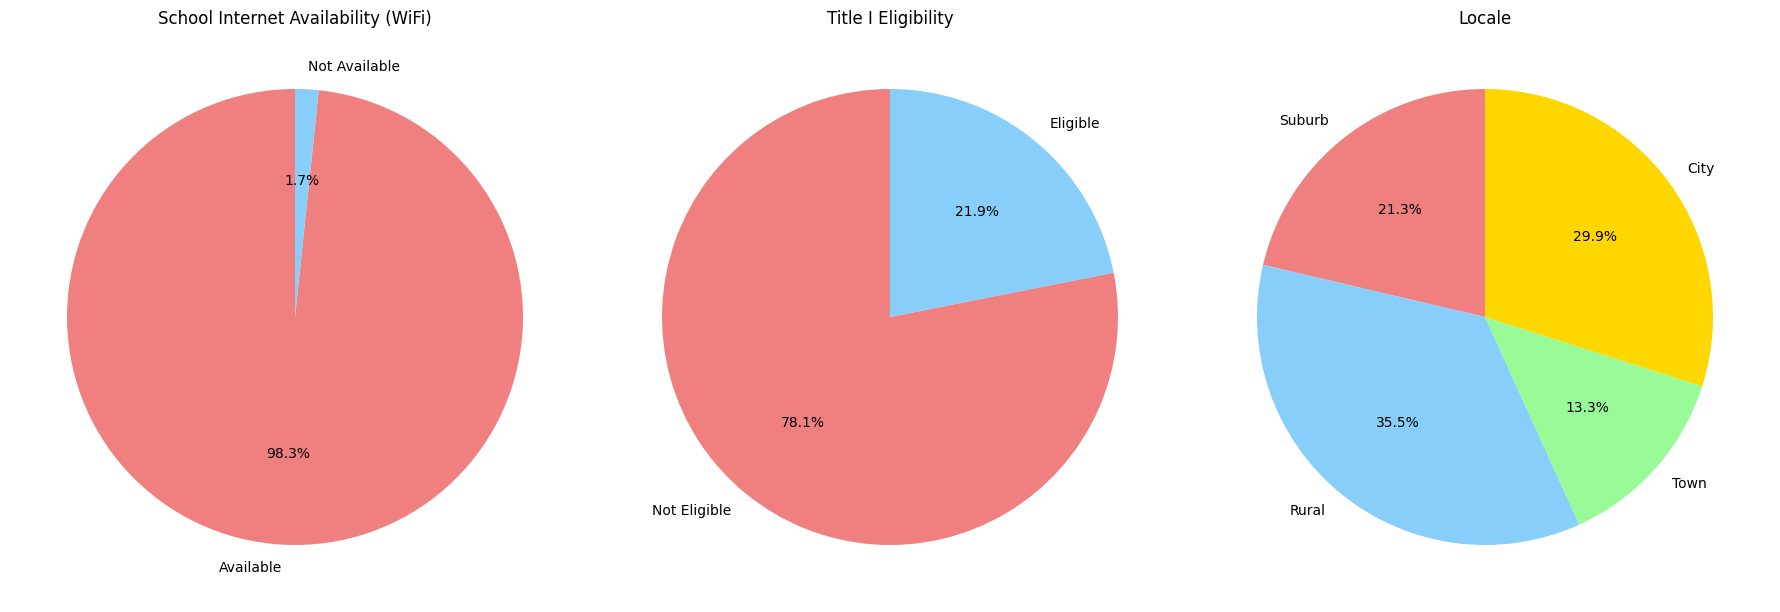

In [7]:
# Create pie charts for categorical features
# Create subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Pie chart for 'sch_internet_wifi'
wifi_counts = df_cleaned['sch_internet_wifi'].value_counts()
axes[0].pie(wifi_counts, labels=['Available', 'Not Available'], autopct='%1.1f%%', startangle=90, colors=['lightcoral', 'lightskyblue'])
axes[0].set_title('School Internet Availability (WiFi)')

# Pie chart for 'title_i_eligible'
title_i_counts = df_cleaned['title_i_eligible'].value_counts()
axes[1].pie(title_i_counts, labels=['Not Eligible', 'Eligible'], autopct='%1.1f%%', startangle=90, colors=['lightcoral', 'lightskyblue'])
axes[1].set_title('Title I Eligibility')

# Pie chart for locale (Suburb, Rural, Town, City)
# Sum each of these columns to get the overall distribution of locales
locale_counts = [
    df_cleaned['locale_Suburb'].sum(),
    df_cleaned['locale_Rural'].sum(),
    df_cleaned['locale_Town'].sum(),
    df_cleaned['locale_City'].sum()
]
locale_labels = ['Suburb', 'Rural', 'Town', 'City']
axes[2].pie(locale_counts, labels=locale_labels, autopct='%1.1f%%', startangle=90, colors = ['lightcoral', 'lightskyblue', 'palegreen', 'gold'])
axes[2].set_title('Locale')

# Display all charts
plt.tight_layout()
plt.show()

In [8]:
# Target data is grad_rate
y = df_cleaned['grad_rate']

# Remove target and plotting data from features
X = df_cleaned.drop(columns=['grad_rate', 'city_location', 'latitude', 'longitude'])

#Data splitting (train, test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#Standardize features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# PCA
pca = PCA(n_components=2)
#X_train = pca.fit_transform(X_train)
#X_test = pca.fit_transform(X_test)

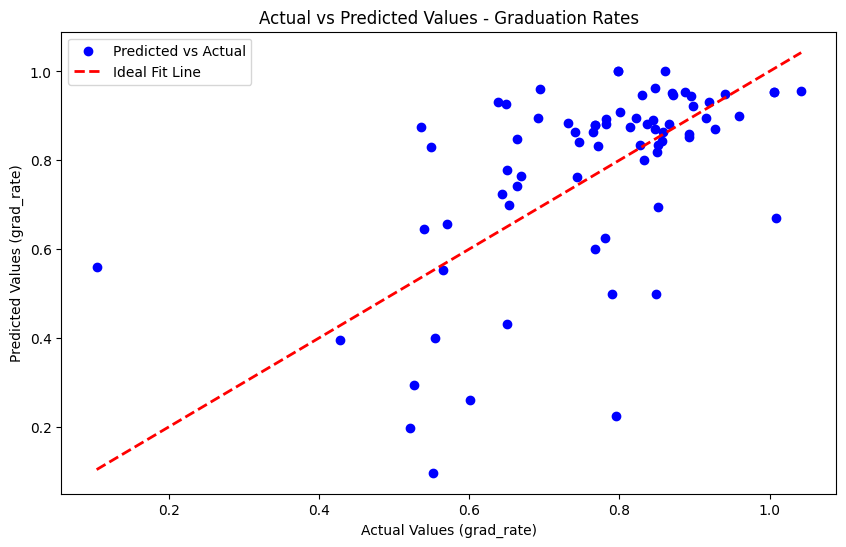

Linear Regression Model 1:
Explanatory features ['enrollment', 'sch_internet_wifi', 'students_SAT_ACT', 'enrl_biology', 'students_susp_in_sch', 'students_susp_out_sch_single', 'students_susp_out_sch_multiple', 'days_suspended', 'suspensions_instances', 'teachers_fte_crdc', 'teachers_certified_fte', 'teachers_absent_fte', 'instructional_aides_fte', 'counselors_fte', 'support_fte', 'social_workers_fte', 'administration_fte', 'psychologists_fte', 'nurses_fte', 'law_enforcement_fte', 'security_guard_fte', 'salaries_teachers', 'salaries_total', 'salaries_instruc_staff', 'salaries_instructional_aides', 'salaries_support', 'salaries_administration', 'expenditures_nonpersonnel', 'title_i_eligible', 'locale_City', 'locale_Rural', 'locale_Suburb', 'locale_Town']
Mean Absolute Error: 0.13260263609054868
Mean Squared Error: 0.0322750770679543
Root Mean Squared Error: 0.1796526567238968
R-squared: 0.2684701354653024
Adjusted R-squared: -0.35051667298713385


In [18]:
# Model 1: Linear Regression
from sklearn.linear_model import LinearRegression

model = LinearRegression()
model.fit(X_train, y_train)
y_hat = model.predict(X_test)

plt.figure(figsize=(10, 6))
plt.scatter(y_hat, y_test, color='blue', label='Predicted vs Actual')
plt.plot([y_hat.min(), y_hat.max()], [y_hat.min(), y_hat.max()], 'r--', lw=2, label='Ideal Fit Line')
plt.xlabel('Actual Values (grad_rate)')
plt.ylabel('Predicted Values (grad_rate)')
plt.title('Actual vs Predicted Values - Graduation Rates')
plt.legend()
plt.show()
# This model ok, but it could be better.

mae = mean_absolute_error(y_test, y_hat)
mse = mean_squared_error(y_test, y_hat)
r2 = r2_score(y_test, y_hat)
n = len(y_test)
p = X_test.shape[1]
adjusted_r2 = 1 - ((1 - r2) * (n - 1)) / (n - p - 1)

print(f"Linear Regression Model 1:")
print(f"Explanatory features", X.columns.tolist())
print(f"Mean Absolute Error: {mae}")
print(f"Mean Squared Error: {mse}")
print(f"Root Mean Squared Error: {np.sqrt(mse)}")
print(f"R-squared: {r2}")
print(f"Adjusted R-squared: {adjusted_r2}")

Selected features: Index(['enrollment', 'students_susp_out_sch_single', 'suspensions_instances',
       'teachers_fte_crdc', 'teachers_absent_fte', 'counselors_fte',
       'social_workers_fte', 'salaries_teachers', 'salaries_total',
       'locale_Rural'],
      dtype='object')


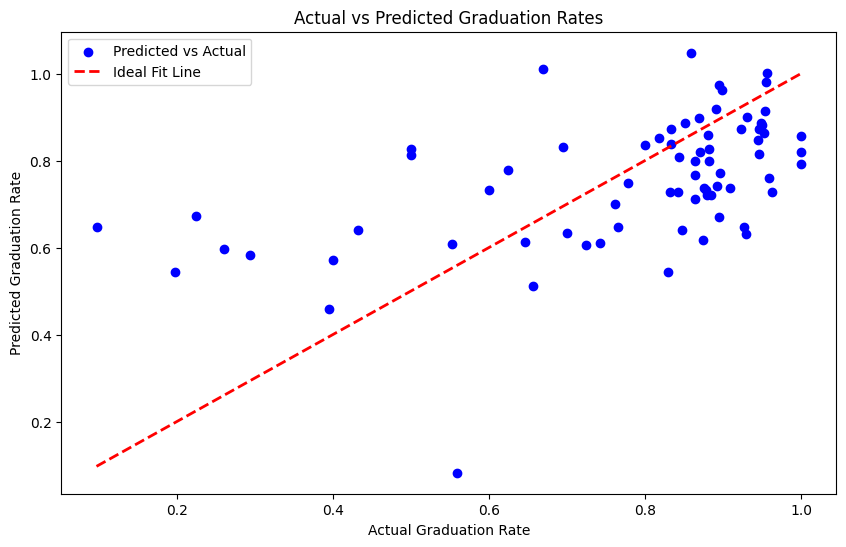

Linear Regression Model 2: 
Explanatory features Index(['enrollment', 'students_susp_out_sch_single', 'suspensions_instances',
       'teachers_fte_crdc', 'teachers_absent_fte', 'counselors_fte',
       'social_workers_fte', 'salaries_teachers', 'salaries_total',
       'locale_Rural'],
      dtype='object')
Mean Absolute Error: 0.14607830414885037
Mean Squared Error: 0.034691673241166274
Root Mean Squared Error: 0.18625700856925162
R-squared: 0.21369684189569338
Adjusted R-squared: 0.0868737518788697


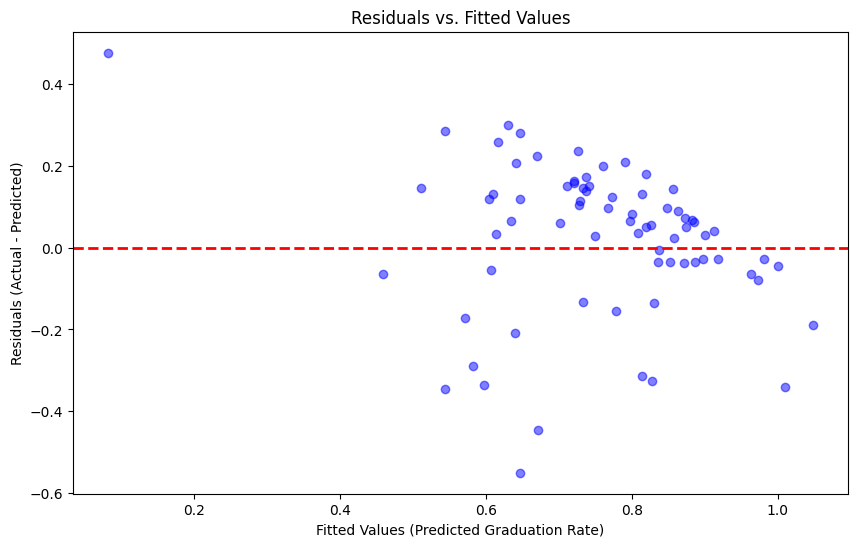

In [10]:
# Linear Regression Model 2
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFECV

X_train_df = pd.DataFrame(X_train, columns=X.columns)

# Using a selector to determine the best features based on MSE

selector = RFECV(model, step=0.1, cv=5, scoring='neg_mean_squared_error', min_features_to_select=10)
selector.fit(X_train_df, y_train)

selected_features = X_train_df.columns[selector.support_]
print("Selected features:", selected_features)

X_train_selected = X_train_df.loc[:, selector.support_]
X_test_selected = pd.DataFrame(X_test, columns=X.columns).loc[:, selector.support_]

# Training Model
model = LinearRegression()
model.fit(X_train_selected, y_train)

y_pred = model.predict(X_test_selected)

# Plotting
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, color='blue', label='Predicted vs Actual')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2, label='Ideal Fit Line')
plt.xlabel('Actual Graduation Rate')
plt.ylabel('Predicted Graduation Rate')
plt.title('Actual vs Predicted Graduation Rates')
plt.legend()
plt.show()

# Evaluation
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

n = len(y_test)
p = X_test_selected.shape[1]

adjusted_r2 = 1 - ((1 - r2) * (n - 1)) / (n - p - 1)


print(f"Linear Regression Model 2: ")
print(f"Explanatory features", selected_features)
print(f"Mean Absolute Error: {mae}")
print(f"Mean Squared Error: {mse}")
print(f"Root Mean Squared Error: {np.sqrt(mse)}")
print(f"R-squared: {r2}")
print(f"Adjusted R-squared: {adjusted_r2}")

# Residuals versus fitted plot
residuals = y_test - y_pred  # y_test and y_pred should be in the original scale of the target

# Plot residuals vs. fitted values
plt.figure(figsize=(10, 6))
plt.scatter(y_pred, residuals, color='blue', alpha=0.5)
plt.axhline(0, color='red', linestyle='--', lw=2)
plt.xlabel('Fitted Values (Predicted Graduation Rate)')
plt.ylabel('Residuals (Actual - Predicted)')
plt.title('Residuals vs. Fitted Values')

plt.show()

# Variation doesnt appear to be a concern, but the residuals are a bit high, so I will try a
# log transform or something.

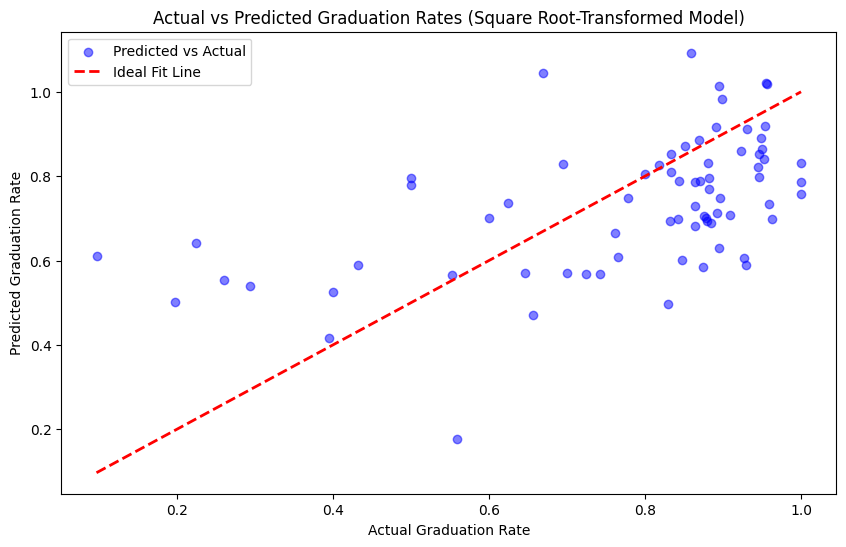

Linear Regression Model 2 (Square Root Transformed): 
Explanatory features Index(['enrollment', 'students_susp_out_sch_single', 'suspensions_instances',
       'teachers_fte_crdc', 'teachers_absent_fte', 'counselors_fte',
       'social_workers_fte', 'salaries_teachers', 'salaries_total',
       'locale_Rural'],
      dtype='object')
Mean Absolute Error: 0.1565654331437638
Mean Squared Error: 0.03663662509700739
Root Mean Squared Error: 0.19140696198677673
R-squared: 0.16961358952624694
Adjusted R-squared: 0.0356802975143512


In [15]:
# Linear Regression Model 2 with Transformations

# Apply square root transformation to target
y_train_sqrt = np.sqrt(y_train)
y_test_sqrt = np.sqrt(y_test)

# Train the model on the square root-transformed target
model = LinearRegression()
model.fit(X_train_selected, y_train_sqrt)

# Predict and transform back to the original scale
y_pred_sqrt = model.predict(X_test_selected)
y_pred = np.square(y_pred_sqrt)

plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, color='blue', alpha=0.5, label='Predicted vs Actual')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2, label='Ideal Fit Line')
plt.xlabel('Actual Graduation Rate')
plt.ylabel('Predicted Graduation Rate')
plt.title('Actual vs Predicted Graduation Rates (Square Root-Transformed Model)')
plt.legend()
plt.show()

# Evaluation
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
n = len(y_test)
p = X_test_selected.shape[1]
adjusted_r2 = 1 - ((1 - r2) * (n - 1)) / (n - p - 1)

print(f"Linear Regression Model 2 (Square Root Transformed): ")
print(f"Explanatory features", selected_features)
print(f"Mean Absolute Error: {mae}")
print(f"Mean Squared Error: {mse}")
print(f"Root Mean Squared Error: {np.sqrt(mse)}")
print(f"R-squared: {r2}")
print(f"Adjusted R-squared: {adjusted_r2}")

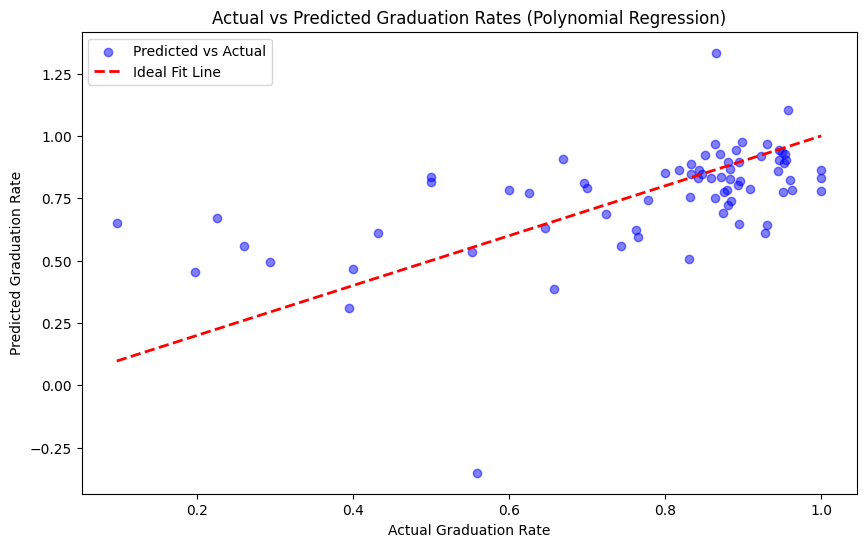

Linear Regression Model 2 (Polynomial Transformed): 
Explanatory features Index(['enrollment', 'students_susp_out_sch_single', 'suspensions_instances',
       'teachers_fte_crdc', 'teachers_absent_fte', 'counselors_fte',
       'social_workers_fte', 'salaries_teachers', 'salaries_total',
       'locale_Rural'],
      dtype='object')
Mean Absolute Error: 0.14113857851572106
Mean Squared Error: 0.041824568696891974
Root Mean Squared Error: 0.20451055888851308
R-squared: 0.052026397686343206
Adjusted R-squared: -0.10087257042876274


In [16]:
# Linear Regression Model 2 with Polynomial Transformation:
from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

polynomial_model = make_pipeline(PolynomialFeatures(degree=2), Ridge(alpha=1.0))
polynomial_model.fit(X_train_selected, y_train)

# Predict on the test set
y_pred = polynomial_model.predict(X_test_selected)

# Plot actual vs. predicted values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, color='blue', alpha=0.5, label='Predicted vs Actual')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2, label='Ideal Fit Line')
plt.xlabel('Actual Graduation Rate')
plt.ylabel('Predicted Graduation Rate')
plt.title('Actual vs Predicted Graduation Rates (Polynomial Regression)')
plt.legend()
plt.show()

# Evaluation
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
n = len(y_test)
p = X_test_selected.shape[1]
adjusted_r2 = 1 - ((1 - r2) * (n - 1)) / (n - p - 1)

print(f"Linear Regression Model 2 (Polynomial Transformed): ")
print(f"Explanatory features", selected_features)
print(f"Mean Absolute Error: {mae}")
print(f"Mean Squared Error: {mse}")
print(f"Root Mean Squared Error: {np.sqrt(mse)}")
print(f"R-squared: {r2}")
print(f"Adjusted R-squared: {adjusted_r2}")

Best Parameters: {'criterion': 'squared_error', 'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}
Mean Absolute Error: 0.1098360542325255
Mean Squared Error: 0.02396543642554295
Root Mean Squared Error: 0.15480774019907065
R-squared: 0.4568120650810412


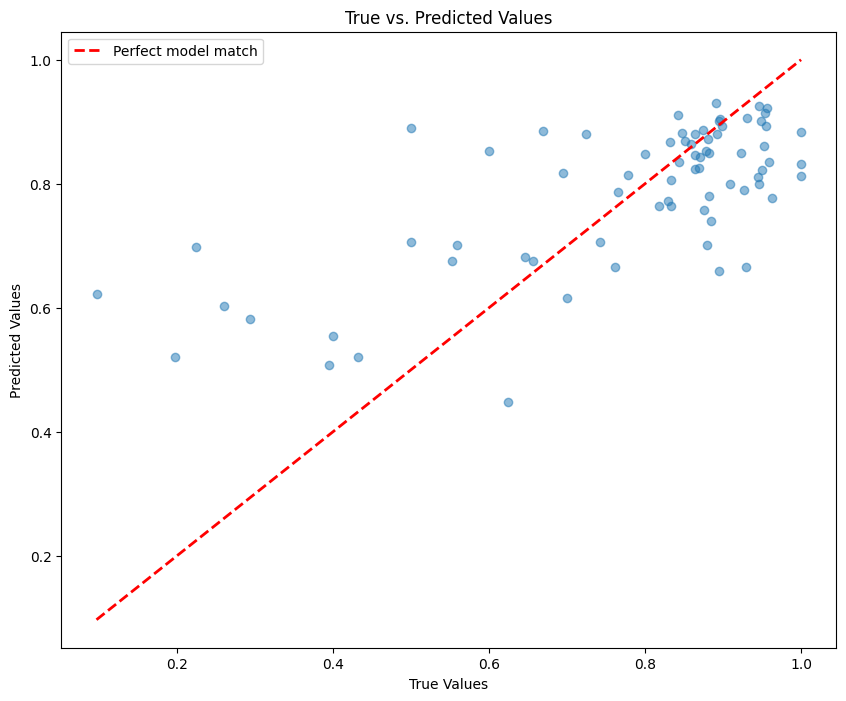

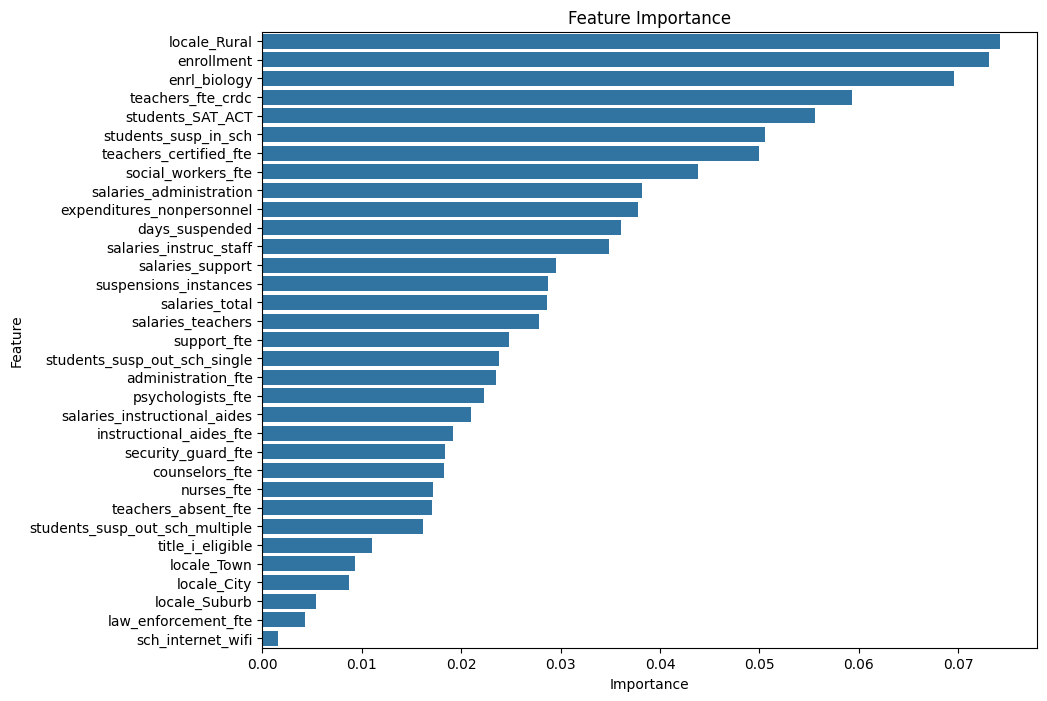

In [17]:
# Model 2: Random Forest

# Initialize model
rf = RandomForestRegressor(random_state=42)

# Grid search for best hyperparameters
param_grid = {
    'n_estimators': [50, 100, 200],
    'criterion': ['squared_error', 'absolute_error'],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2']
}
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, cv = 5, n_jobs = -1, scoring = 'neg_mean_squared_error')
grid_search.fit(X_train, y_train)

# Take best model
print("Best Parameters:", grid_search.best_params_)
best_rf = grid_search.best_estimator_

# Predict using best model
y_pred = best_rf.predict(X_test)

# Evaluate model performance
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Absolute Error: {mae}")
print(f"Mean Squared Error: {mse}")
print(f"Root Mean Squared Error: {np.sqrt(mse)}")
print(f"R-squared: {r2}")

# Plot actual vs predicted values
plt.figure(figsize=(10, 8))
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw = 2, color = 'red', label = 'Perfect model match')
plt.legend()
plt.scatter(y_test, y_pred, alpha=0.5)
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.title('True vs. Predicted Values')
plt.show()

# Plot feature importance
plt.figure(figsize=(10, 8))
sns.barplot(x='Importance', y='Feature', data = pd.DataFrame({'Feature': X.columns, 'Importance': best_rf.feature_importances_}).sort_values(by = "Importance", ascending = False))
plt.title('Feature Importance')
plt.show()